In [1]:
!git clone https://github.com/supreme-gg-gg/ddpg-stock-rl
%cd ddpg-stock-rl/src

Cloning into 'ddpg-stock-rl'...
remote: Enumerating objects: 1159, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1159 (delta 148), reused 151 (delta 101), pack-reused 945 (from 2)
Receiving objects: 100% (1159/1159), 35.14 MiB | 9.70 MiB/s, done.
Resolving deltas: 100% (613/613), done.
Updating files: 100% (102/102), done.
/content/ddpg-stock-rl/src


In [ ]:
"""
Use DDPG to train a stock trader based on a window of history price
"""

from __future__ import print_function, division

import numpy as np

from model.ddpg.actor import StockActor, StockActorPVM
from model.ddpg.critic import StockCritic, StockCriticPVM
from model.ddpg.ddpg import DDPGAgent
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

from environment.portfolio import PortfolioEnv
from utils.data import read_stock_history, obs_normalizer
from utils.helpers import get_model_path, get_result_path

if __name__ == '__main__':

    window_length = 7
    predictor_type = 'lstm'
    use_batch_norm = True
    tau = 1e-3
    batch_size = 64
    action_bound = 1.
    actor_lr = 0.00001
    critic_lr = 0.0001
    gamma = 0.99
    pvm = True

    num_training_time = 1095

    # load the data
    history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
    history = history[:, :, :4]
    target_stocks = abbreviation
    nb_classes = len(target_stocks) + 1

    # get target history
    target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))
    for i, stock in enumerate(target_stocks):
        target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

    # setup environment
    env = PortfolioEnv(target_history, target_stocks, steps=1000, window_length=window_length, pvm=pvm)

    # do some setup and checking
    action_dim = [nb_classes]
    state_dim = [nb_classes, window_length]


    model_save_path = get_model_path(window_length, predictor_type, use_batch_norm, pvm)
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm, pvm)

    # create actor critic noise and agent
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))
    if pvm:
        actor = StockActorPVM(state_dim, action_dim, action_bound, actor_lr, tau, batch_size,
                            predictor_type, use_batch_norm)
        critic = StockCriticPVM(state_dim=state_dim, action_dim=action_dim, learning_rate=critic_lr, tau=1e-3,
                             predictor_type=predictor_type, use_batch_norm=use_batch_norm)
        ddpg_model = DDPGAgent(env, actor, critic, gamma, actor_noise, obs_normalizer=obs_normalizer, pvm=True,
                        config_file='config/stock.json', model_save_path=model_save_path,
                        summary_path=summary_path)
    else:
        actor = StockActor(state_dim, action_dim, action_bound, actor_lr, tau, batch_size,
                            predictor_type, use_batch_norm)
        critic = StockCritic(state_dim=state_dim, action_dim=action_dim, learning_rate=critic_lr, tau=1e-3,
                                predictor_type=predictor_type, use_batch_norm=use_batch_norm)
        ddpg_model = DDPGAgent(env, actor, critic, gamma, actor_noise, obs_normalizer=obs_normalizer, pvm=False,
                        config_file='config/stock.json', model_save_path=model_save_path,
                        summary_path=summary_path)
    ddpg_model.train() # this saves automatically

    # TODO: Check if action_processor is necessary, it is NOT used in the original code but
    # seems to have support built-in in the networks.



Episode: 0, Reward: 0.12, Avg Q: 0.0072
Episode: 1, Reward: -0.04, Avg Q: 0.0057
Episode: 2, Reward: 0.26, Avg Q: 0.0052
Episode: 3, Reward: 0.32, Avg Q: 0.0050
Episode: 4, Reward: 0.30, Avg Q: 0.0050
Episode: 5, Reward: 0.52, Avg Q: 0.0049
Episode: 6, Reward: 0.41, Avg Q: 0.0049
Episode: 7, Reward: 0.16, Avg Q: 0.0053
Episode: 8, Reward: 0.13, Avg Q: 0.0053
Episode: 9, Reward: 0.05, Avg Q: 0.0049
Episode: 10, Reward: 0.05, Avg Q: 0.0046
Episode: 11, Reward: 0.44, Avg Q: 0.0048
Episode: 12, Reward: 0.49, Avg Q: 0.0049
Episode: 13, Reward: 0.30, Avg Q: 0.0046
Episode: 14, Reward: -0.04, Avg Q: 0.0049
Episode: 15, Reward: 0.08, Avg Q: 0.0049
Episode: 16, Reward: -0.11, Avg Q: 0.0048
Episode: 17, Reward: -0.15, Avg Q: 0.0049
Episode: 18, Reward: 0.65, Avg Q: 0.0052
Episode: 19, Reward: 0.53, Avg Q: 0.0050
Episode: 20, Reward: 0.66, Avg Q: 0.0051
Episode: 21, Reward: 0.62, Avg Q: 0.0052
Episode: 22, Reward: 0.13, Avg Q: 0.0051
Episode: 23, Reward: 0.43, Avg Q: 0.0049
Episode: 24, Reward: 0

KeyboardInterrupt: 

/content/ddpg-stock-rl/src/model/ddpg/ddpg.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.model_save_path, map_location=self.device)


Model loaded from weights/stock/lstm/window_3/batch_norm/pvm/checkpoint.ckpt


<Figure size 640x480 with 0 Axes>

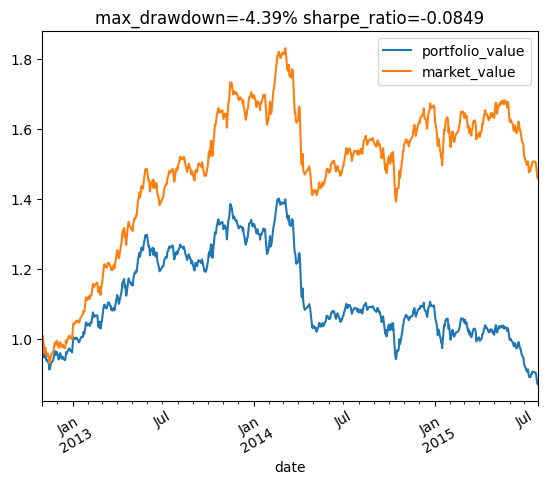

In [ ]:
import numpy as np

from model.ddpg.actor import StockActor, StockActorPVM
from model.ddpg.critic import StockCritic, StockCriticPVM
from model.ddpg.ddpg import DDPGAgent
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

from environment.portfolio import PortfolioEnv
from utils.data import read_stock_history, obs_normalizer
from utils.helpers import get_model_path, get_result_path

num_training_time = 1095
window_length = 3
predictor_type = 'lstm'
use_batch_norm = True
tau = 1e-3
batch_size = 64
action_bound = 1.
actor_lr = 0.0001
critic_lr = 0.001
gamma = 0.99
pvm = True

history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target_2.h5')
history = history[:, :, :4]
target_stocks = abbreviation
nb_classes = len(target_stocks) + 1

# get target history
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# setup environment

# do some setup and checking
action_dim = [nb_classes]
state_dim = [nb_classes, window_length]




name = 'DDPG_window_3_predictor_lstm'.format(window_length, predictor_type)

action_dim = [nb_classes]
state_dim = [nb_classes, window_length]

actor = StockActorPVM(state_dim=state_dim, action_dim=action_dim, action_bound=action_bound, learning_rate=actor_lr, tau=tau,
                  batch_size = batch_size, predictor_type=predictor_type, use_batch_norm=use_batch_norm)
critic = StockCriticPVM(state_dim=state_dim, action_dim=action_dim, learning_rate=critic_lr, tau=tau,
                        predictor_type=predictor_type, use_batch_norm=use_batch_norm)
actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

model_save_path = get_model_path(window_length, predictor_type, use_batch_norm, pvm)
summary_path = get_result_path(window_length, predictor_type, use_batch_norm, pvm)

ddpg_model = DDPGAgent(None, actor, critic, 0.001, actor_noise, obs_normalizer=obs_normalizer, pvm=pvm,
                  config_file='config/stock.json', model_save_path=model_save_path,
                  summary_path=summary_path)

# NOTE: We got rid of the initialize() function because you either load or bulid from scratch directly
ddpg_model.load_model()

from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv
from utils.helpers import test_model_pvm
env = PortfolioEnv(target_history, target_stocks, steps=1000, window_length = 10, sample_start_date='2012-10-30', pvm=pvm)

test_model_pvm(env, ddpg_model)